In [73]:
import os
import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd


In [74]:
# The outputs of the linear regression, which are our input
output_dir_base = r"D:\01 Files\04 University\00 Internships and theses\2. AI internship\EEG data\linreg final outputs"
# Info identifying the arch, checkpoint, version of code and whatever
#run_dir = "2024-02-16_15-54-47 - v2 resnet18 ch200"
#run_dir = "2024-02-22_11-49-01 UNTRAINED_RESNET18"
#run_dir = "no."

# Merge them
#output_dir = os.path.join(output_dir_base, run_dir)


# Add text to graph titles, if needed
additional_title_info = ""

#selected_layers = ["fc2"] 
selected_layers = ["layer1", "layer2", "layer3", "layer4"]#, "fc2"]


n_timepoints = 512
downsampling_factor = 4

# List of selected subjects
selected_subjects = range(5,36)

#selected_channels = ['Iz', 'Oz', 'POz', 'P3', 'P4']
selected_channels = ['Iz', 'Oz', 'POz', 'AVR']

original_sampling_rate = 1024

# EEG channels by name (const)
channel_order = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'left', 'right', 'above', 'below']
# All visual channels
visual_channel_names = ['O1', 'O2', 'Oz', 'Iz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO7', 'POz', 'PO4', 'PO8']


# Get indexes of the selected channels
#selected_channel_indexes = [channel_order.index(channel) for channel in selected_channels]

In [3]:
def read_data(output_dir):
    
    all_info = {}
    
    # Initialize lists to hold flattened data
    subject_list = []
    layer_list = []
    channel_list = []
    stat_list = []
    timepoint_list = []
    value_list = []
    
    # Loop over all data and load everything
    for sub in selected_subjects:
        # Make dir
        subject_dir = os.path.join(output_dir, f"sub_{sub}")
    
        subject_info = {}
        
        for layer_name in selected_layers:
            # Get dir
            layer_dir = os.path.join(subject_dir, layer_name)
    
            # Dicts for all channels
    
            layer_info = {}
            
            for channel in selected_channels:
                #channel_name = channel_order[channel]
                # Get dir
                channel_dir = os.path.join(layer_dir, channel)
    
                # Load data
                #train_rs = np.load(os.path.join(channel_dir, "train_rs.npy"))
                #train_r2s = np.load(os.path.join(channel_dir, "train_r2s.npy"))
                #train_betas = np.load(os.path.join(channel_dir, "train_betas.npy"))
                #train_lin_regs = np.load(os.path.join(channel_dir, "train_lin_regs.npy"))
                test_rs = np.load(os.path.join(channel_dir, "test_rs.npy"))
                test_r2s = np.load(os.path.join(channel_dir, "test_r2s.npy"))
    
                channel_data = {
                #'train_rs': train_rs,
                #'train_r2s': train_r2s,
                #'train_betas': train_betas,
                #'train_lin_regs': train_lin_regs,
                'test_rs': test_rs,
                'test_r2s': test_r2s,
                #'test_betas': test_betas
                }
                
                layer_info[channel] = channel_data
    
                # save the data length
                downsampled_num_points = len(test_rs)
    
    
                # Also make a "flat" list for pandas
                for stat, timepoints_array in channel_data.items():
                    # Append the corresponding subject, layer, channel, stat for each timepoint
                    for idx, timepoint in enumerate(timepoints_array):
                        subject_list.append(sub)
                        layer_list.append(layer_name)
                        channel_list.append(channel)
                        stat_list.append(stat)
                        timepoint_list.append(idx)
                        value_list.append(timepoint)
    
            #plot_layer(layer_info, layer_name, sub)
            
            subject_info[layer_name] = layer_info
        #plot_subject(subject_info)
        
        all_info[sub] = subject_info
    #plot_whatever(all_info)
    
    # save the data length
    n_timepoint = len(test_rs)
    
    
    # Create a pandas df
    data_flat = pd.DataFrame({
        'Subject': subject_list,
        'Layer': layer_list,
        'Channel': channel_list,
        'Stat': stat_list,
        'Timepoint': timepoint_list,
        'Value': value_list
    })

    return data_flat #, all_info



In [6]:
# Load multiple models

def get_test_data(run_dir_m):
    output_dir = os.path.join(output_dir_base, run_dir_m)
    data_flat = read_data(output_dir)

    # Add the model in a new column
    data_flat['Model']=run_dir_m
    
    #train_rs_df = data_flat[data_flat['Stat'] == 'train_rs']
    #train_r2s_df = data_flat[data_flat['Stat'] == 'train_r2s']
    test_rs_df = data_flat[data_flat['Stat'] == 'test_rs']
    test_r2s_df = data_flat[data_flat['Stat'] == 'test_r2s']

    return test_rs_df, test_r2s_df

# Start reading data
#test_rs_df1, test_r2s_df1 = get_test_data("OADS")
#test_rs_df2, test_r2s_df2 = get_test_data("OADSx6")
test_rs_df3, test_r2s_df3 = get_test_data("OADSx30")
test_rs_df4, test_r2s_df4 = get_test_data("STL10")
test_rs_df5, test_r2s_df5 = get_test_data("Untrained")
test_rs_df6, test_r2s_df6 = get_test_data("Supervised ResNet18 + OADS OC")



In [9]:
# Put everything in one df
#test_rs_df = pd.concat([test_rs_df1, test_rs_df2, test_rs_df3, test_rs_df4, test_rs_df5, test_rs_df6])
#test_r2s_df = pd.concat([test_r2s_df1, test_r2s_df2, test_r2s_df3, test_r2s_df4, test_r2s_df5, test_r2s_df6])

test_rs_df = pd.concat([test_rs_df3, test_rs_df4, test_rs_df5, test_rs_df6])
test_r2s_df = pd.concat([test_r2s_df3, test_r2s_df4, test_r2s_df5, test_r2s_df6])

# Change niklas version fc to fc2 or change fc2 to fc
#test_rs_df['Layer'].replace('fc2', 'fc', inplace=True)
#test_r2s_df['Layer'].replace('fc2', 'fc', inplace=True)

# Add proper time in ms
# Mapping -100 to 400 ms to the range of timepoints
custom_xlim = (-100, 400)
timepoint_range = (test_rs_df['Timepoint'].min(), test_rs_df['Timepoint'].max())

# Calculate the mapping factor
time_mapping_factor = (timepoint_range[1] - timepoint_range[0]) / (custom_xlim[1] - custom_xlim[0])

# Map timepoints to the custom time range using .loc
test_rs_df.loc[:, 'Time_mapped'] = (test_rs_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]
test_r2s_df.loc[:, 'Time_mapped'] = (test_r2s_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]


In [ ]:

# Skip all the above and load the df

test_rs_df = pd.read_csv(r"D:\00 Downloads\eeg_results_n_stats.csv")


In [ ]:
# STATS + fdrcorrection


import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from itertools import combinations

# Run on pearson rs
all_data = test_rs_df

# Get unique timepoints
timepoints = all_data['Timepoint'].unique()

# Get unique models
models = all_data['Model'].unique()

# Initialize significance arrays for each layer and channel
layer_channel_significance = {}

# Perform pairwise comparisons at each timepoint for each layer and channel
for layer_name in selected_layers:
    for channel in selected_channels:
        # Get data for this layer and channel
        data_layer_channel = all_data[(all_data['Layer'] == layer_name) & (all_data['Channel'] == channel)]
        
        # Initialize significance array for this layer and channel
        n_timepoints = len(timepoints)
        n_models = len(models)
        significance_array = np.zeros((n_timepoints, n_models, n_models), dtype=bool)
        
        # Perform pairwise comparisons at each timepoint
        for i, timepoint in tqdm(enumerate(timepoints), desc=f"Layer: {layer_name}, Channel: {channel}"):
            # Get data for this timepoint
            data_timepoint = data_layer_channel[data_layer_channel['Timepoint'] == timepoint]
            for model1, model2 in combinations(models, 2):
                # Get data for each model
                values_model1 = data_timepoint[data_timepoint['Model'] == model1]['Value']
                values_model2 = data_timepoint[data_timepoint['Model'] == model2]['Value']

                # Perform t-test
                _, p_value = ttest_ind(values_model1, values_model2)

                # Apply FDR correction
                significant = fdrcorrection([p_value])[0][0]

                # Store significance
                idx1 = np.where(models == model1)[0][0]
                idx2 = np.where(models == model2)[0][0]
                significance_array[i, idx1, idx2] = significant
                significance_array[i, idx2, idx1] = significant
        
        # Store significance array for this layer and channel
        layer_channel_significance[(layer_name, channel)] = significance_array

print("done")


In [165]:
layer_channel_significance[('layer4', 'AVR')].shape



(129, 4, 4)

In [203]:
def get_significance_arr(layer, channel, compare_model, other_model_idx):

    factor = 500/128 # 3.90625, the downsample factor
    
    significance_array = layer_channel_significance[(layer, channel)]
    significant_timepoints = significance_array[:, compare_model, other_model_idx]
    
    tp_indices = [index for index, value in enumerate(significant_timepoints) if value] # they are of the downsampled timepoints
    timepoints = [(index * factor - 100) for index in tp_indices] # convert to real timpoints
    return timepoints


significant_timepoints = get_significance_arr("layer1", "AVR", 0 , 2)
len(significant_timepoints)

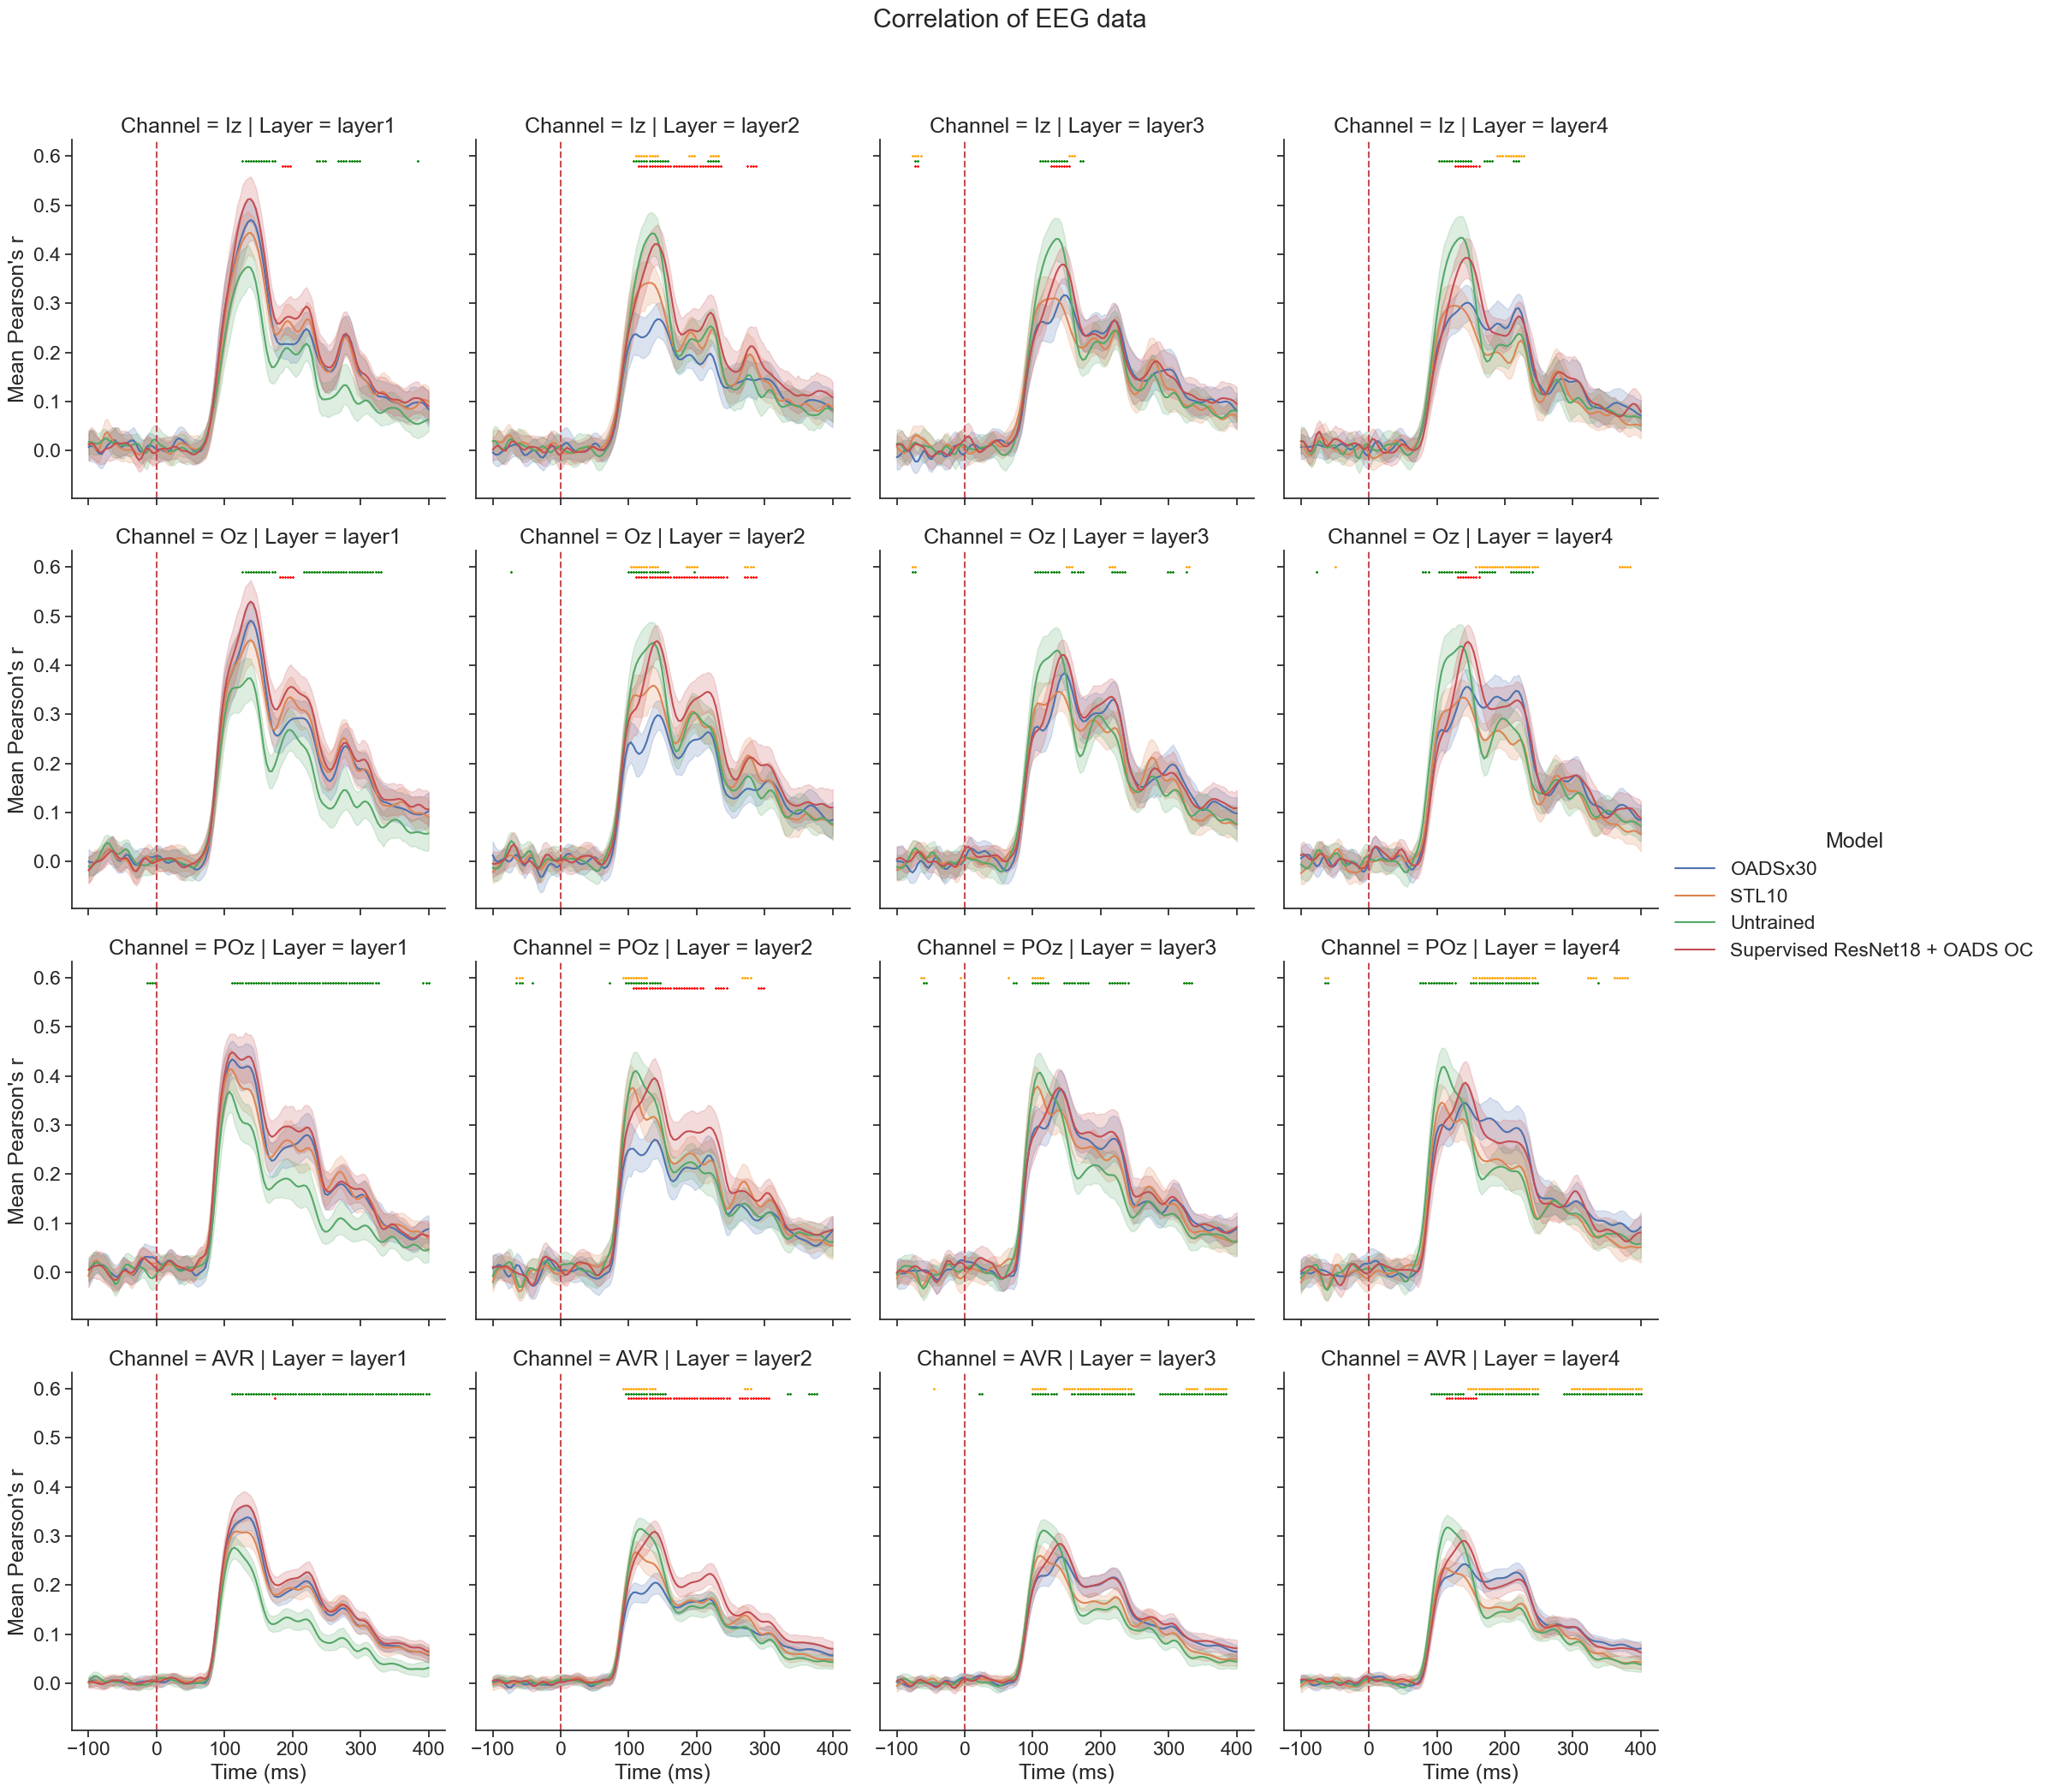

In [207]:
# Plot with significance values

# plot a chosen one, and include it's real significance datas

# Plot models against each other
import seaborn
import re


seaborn.set(font_scale=1.5)
seaborn.set_style('ticks')

# Choose some specific layer or channel or whatever
#data = test_rs_df[test_rs_df['Channel'] == 'AVR']
#data = data[data['Layer'] == 'layer1']

# Use all allah wakbar
data = test_rs_df


# Correlation
my_plot = seaborn.relplot(data=data, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")

# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"Correlation of EEG data", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)

# replace labels
#new_labels = ['SimCLR-ResNet18 (6x Cropped-OADS)', 'Supervised ResNet18', 'Untrained ResNet18']
#for t, l in zip(my_plot._legend.texts, new_labels):
#    t.set_text(l)


# Add stats to the graph!
# Get the number of models
num_models = len(models)
            
# Scale the timepoints and shift them to reflect the actual time range
scaled_timepoints = [(tp * 4) - 100 for tp in timepoints]

# Model to compare against
compare_model = 0

# Should match the color of the graph of the model, so by order
colors_order = ["blue", "orange", "green", "red"]

other_model_idxs = numbers_list = [num for num in range(4) if num != compare_model]


# Highest to draw the things
init_height_const = 0.6

# Iterate over each subplot
for row in range(len(my_plot.axes)):
    
    for col in range(len(my_plot.axes[row])):
        # Get the current axis
        ax = my_plot.axes[row, col]
        
        # Extract channel and layer from the title string
        title = ax.get_title()
        match = re.match(r'Channel = (\w+) \| Layer = (\w+)', title)
        if match:
            channel = match.group(1)
            layer = match.group(2)

            # TODO: change it to work on a list of models
            height = init_height_const
            for other_model_idx in other_model_idxs:
                other_model = models[other_model_idx]
                
                # get list of timepoints with significant vals
                significant_timepoints = get_significance_arr(layer, channel, compare_model, other_model_idx)
                # Plot them as dots
                ax.scatter(x=significant_timepoints, y=[height for _ in significant_timepoints], color=colors_order[other_model_idx], marker='*', s=1)
                height -= 0.01




In [ ]:
###########################################










#### End of the civilized part of the code










###########################################

In [ ]:
# Plot models against each other (no stats)
import seaborn

seaborn.set(font_scale=1.5)
seaborn.set_style('ticks')

# Choose some specific layer or channel or whatever
data = test_rs_df#[test_rs_df['Channel'] == 'Oz']


# Correlation
my_plot = seaborn.relplot(data=data, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")


# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"Correlation of EEG data", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)




# replace labels
#new_labels = ['SimCLR-ResNet18 (6x Cropped-OADS)', 'Supervised ResNet18', 'Untrained ResNet18']
#for t, l in zip(my_plot._legend.texts, new_labels):
#    t.set_text(l)



In [171]:
# Old stats graphing, basic

import matplotlib.pyplot as plt

def plot_significance(layer_name, channel_name, layer_channel_significance, models, timepoints):
    # Get the significance array for the specified layer and channel
    significance_array = layer_channel_significance[(layer_name, channel_name)]
    
    # Get the number of models
    num_models = len(models)
    
    # Scale the timepoints and shift them to reflect the actual time range
    scaled_timepoints = [(tp * 4) - 100 for tp in timepoints]
    
    # Plot for each combination of models
    for model_idx, model in enumerate(models):
        for other_model_idx in range(model_idx + 1, num_models):
            other_model = models[other_model_idx]
            plt.figure(figsize=(10, 6))
            plt.title(f"Layer: {layer_name}, Channel: {channel_name}, Model Comparison: {model} vs {other_model}")
            plt.xlabel("Time (units)")
            plt.ylabel("Significance")
            
            # Plot significance for each timepoint
            for timepoint_idx, timepoint in enumerate(scaled_timepoints):
                significance = significance_array[timepoint_idx, model_idx, other_model_idx]
                color = 'b' if significance else 'r'
                plt.scatter(timepoint, significance, color=color)
            
            # Add legend for colors
            plt.legend([f"{model} vs {other_model}"], loc='upper right')
            
            # Set x-axis limits to reflect the time range
            plt.xlim(-100, 400)
            
            plt.show()


# Example usage:
# Assuming models and timepoints are defined
# Assuming layer_name and channel_name are provided
plot_significance('layer1', 'AVR', layer_channel_significance, models, timepoints)



In [48]:
# BEWARE DOESNT WORK - UNKNONW BUG CAUSES ALL DATA TO BE THE SAME FOR A TIMEPOINT

# Try something crazy, same code, but mapped to timepoints and saved back to df

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm
from itertools import combinations

# Assuming test_rs_df is defined and contains the original timepoints
all_data = test_rs_df

# Get unique timepoints
timepoints = all_data['Timepoint'].unique()

# Get unique models
models = all_data['Model'].unique()

# Initialize significance arrays for each layer and channel
layer_channel_significance = {}

# Perform pairwise comparisons at each timepoint for each layer and channel
for layer_name in selected_layers:
    for channel in selected_channels:
        # Get data for this layer and channel
        data_layer_channel = all_data[(all_data['Layer'] == layer_name) & (all_data['Channel'] == channel)]
        
        # Initialize significance array for this layer and channel
        n_timepoints = len(timepoints)
        n_models = len(models)
        significance_array = np.zeros((n_timepoints, n_models, n_models), dtype=bool)
        
        # Perform pairwise comparisons at each timepoint
        for i, timepoint in tqdm(enumerate(timepoints), desc=f"Layer: {layer_name}, Channel: {channel}"):
            # Get data for this timepoint
            data_timepoint = data_layer_channel[data_layer_channel['Timepoint'] == timepoint]
            for model1, model2 in combinations(models, 2):
                # Get data for each model
                values_model1 = data_timepoint[data_timepoint['Model'] == model1]['Value']
                values_model2 = data_timepoint[data_timepoint['Model'] == model2]['Value']

                # Perform t-test
                _, p_value = ttest_ind(values_model1, values_model2)

                # Apply FDR correction
                significant = fdrcorrection([p_value])[0][0]

                # Store significance
                idx1 = np.where(models == model1)[0][0]
                idx2 = np.where(models == model2)[0][0]
                significance_array[i, idx1, idx2] = significant
                significance_array[i, idx2, idx1] = significant
        
        # Store significance array for this layer and channel
        layer_channel_significance[(layer_name, channel)] = significance_array

        # Map significance array to the mapped timepoints
        mapped_significance_array = np.zeros((len(test_rs_df), n_models, n_models), dtype=bool)
        for idx, tp in enumerate(test_rs_df['Time_mapped']):
            original_tp_idx = int((tp - custom_xlim[0]) / 4)  # Mapping back to original timepoints
            mapped_significance_array[idx] = significance_array[original_tp_idx]
        
        # Add mapped significance array to DataFrame
        mapped_significance_columns = [f"Significance_{model}" for model in models]
        for idx, col in enumerate(mapped_significance_columns):
            test_rs_df[col] = mapped_significance_array[:, idx, :].tolist()

print("done")


# Expand the values even further, for easier graphing

from tqdm import tqdm
import ast

# Create new columns with NaN values
test_rs_df['Significance_OADSx30_STL10'] = None
test_rs_df['Significance_OADSx30_Untrained'] = None
test_rs_df['Significance_OADSx30_Supervised_ResNet18_OADS_OC'] = None

# Loop through each row in the DataFrame with tqdm
for index, row in tqdm(test_rs_df.iterrows(), total=len(test_rs_df)):
    # Extract the values from the 'Significance_OADSx30' column
    significance_values = ast.literal_eval(row['Significance_OADSx30'])
    
    # Assign the values to new columns
    test_rs_df.loc[index, 'Significance_OADSx30_STL10'] = significance_values[1]
    test_rs_df.loc[index, 'Significance_OADSx30_Untrained'] = significance_values[2]
    test_rs_df.loc[index, 'Significance_OADSx30_Supervised_ResNet18_OADS_OC'] = significance_values[3]

# Display the modified DataFrame
print(test_rs_df)


Layer: layer1, Channel: Iz: 129it [00:02, 54.43it/s]
Layer: layer1, Channel: Oz: 129it [00:02, 49.78it/s]
Layer: layer1, Channel: POz: 129it [00:02, 48.32it/s]
Layer: layer1, Channel: AVR: 129it [00:02, 53.08it/s]
Layer: layer2, Channel: Iz: 129it [00:02, 50.50it/s]
Layer: layer2, Channel: Oz: 129it [00:02, 54.70it/s]
Layer: layer2, Channel: POz: 129it [00:02, 57.74it/s]
Layer: layer2, Channel: AVR: 129it [00:02, 54.06it/s]
Layer: layer3, Channel: Iz: 129it [00:02, 54.83it/s]
Layer: layer3, Channel: Oz: 129it [00:02, 49.01it/s]
Layer: layer3, Channel: POz: 129it [00:02, 52.43it/s]
Layer: layer3, Channel: AVR: 129it [00:02, 51.90it/s]
Layer: layer4, Channel: Iz: 129it [00:02, 56.02it/s]
Layer: layer4, Channel: Oz: 129it [00:02, 56.47it/s]
Layer: layer4, Channel: POz: 129it [00:02, 55.52it/s]
Layer: layer4, Channel: AVR: 129it [00:03, 42.65it/s]


done


In [ ]:
from tqdm import tqdm

# Create new columns with NaN values
test_rs_df['Significance_OADSx30_STL10'] = None
test_rs_df['Significance_OADSx30_Untrained'] = None
test_rs_df['Significance_OADSx30_Supervised_ResNet18_OADS_OC'] = None

# Loop through each row in the DataFrame with tqdm
for index, row in tqdm(test_rs_df.iterrows(), total=len(test_rs_df)):
    # Extract the values from the 'Significance_OADSx30' column
    significance_values = row['Significance_OADSx30']
    
    # Assign the values to new columns
    test_rs_df.loc[index, 'Significance_OADSx30_STL10'] = significance_values[1]
    test_rs_df.loc[index, 'Significance_OADSx30_Untrained'] = significance_values[2]
    test_rs_df.loc[index, 'Significance_OADSx30_Supervised_ResNet18_OADS_OC'] = significance_values[3]

# Display the modified DataFrame
print(test_rs_df)


In [ ]:

# same for R^2

# Choose some specific layer or channel or whatever
data_r2 = test_r2s_df#[test_r2s_df['Channel'] == 'Oz']


my_plot = seaborn.relplot(data=data_r2, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")

# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"TEST $R^2$", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean $R^2$", clear_inner=False)

# replace labels
#new_labels = ['SimCLR-ResNet18 (6x Cropped-OADS)', 'Supervised ResNet18', 'Untrained ResNet18']
#for t, l in zip(my_plot._legend.texts, new_labels):
#    t.set_text(l)

In [ ]:
# Plot more specific data

#test_rs_df3, test_r2s_df3 = get_test_data("2024-03-02_20-37-46_UNTRAINED_SIMclr_RESNET18") # TODO: change to alexnet when its ready

#Time thing again

new_df = test_rs_df3

custom_xlim = (-100, 400)
timepoint_range = (new_df['Timepoint'].min(), new_df['Timepoint'].max())

# Calculate the mapping factor
time_mapping_factor = (timepoint_range[1] - timepoint_range[0]) / (custom_xlim[1] - custom_xlim[0])

new_df.loc[:, 'Time_mapped'] = (new_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]



# Plot models against each other
import seaborn

seaborn.set(font_scale=1.5)
seaborn.set_style('ticks')

# Choose some specific layer or channel or whatever
data = new_df[new_df['Channel'] == 'Oz']


# Correlation
my_plot = seaborn.relplot(data=data, x="Time_mapped", y="Value", hue="Model", col="Layer", row="Channel", kind="line")


# Add xline at x=0 for each plot
for ax in my_plot.axes.flat:
    # Add a vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--')

#my_plot.set_titles('{row_name} {col_name}')
my_plot.fig.suptitle(f"TEST Correlations", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)


# replace labels
#new_labels = ['SimCLR-ResNet18 (6x Cropped-OADS)', 'Supervised ResNet18', 'Untrained ResNet18']
#for t, l in zip(my_plot._legend.texts, new_labels):
#    t.set_text(l)



In [212]:
# Extract the significance array. The array is unique for each timepoint, channel, layer combo, 
#   but not for subjects because it is averaged across subjects...
#   so just use first subject

def get_significance_arr_shitty(layer, channel):

    # Filter the DataFrame based on the given layer and channel, use subject 5 because all subjects have the same data
    filtered_df = test_rs_df[(test_rs_df['Layer'] == layer) & (test_rs_df['Channel'] == channel) & (test_rs_df['Subject'] == 5)]
    
    # Extract timepoints where Significance_OADSx30_Untrained is True
    timepoints = filtered_df[filtered_df['Significance_OADSx30_Untrained'] == True]
    
    return timepoints['Time_mapped'].tolist()




75

In [10]:
### Old plotting

In [ ]:
# Load single model

data_flat = read_data(output_dir)

# Separate to avoid confusion / bugs

train_rs_df = data_flat[data_flat['Stat'] == 'train_rs']
train_r2s_df = data_flat[data_flat['Stat'] == 'train_r2s']
test_rs_df = data_flat[data_flat['Stat'] == 'test_rs']
test_r2s_df = data_flat[data_flat['Stat'] == 'test_r2s']

# Plot (single model) with a corresponding time axis
import seaborn


# Mapping -100 to 400 ms to the range of timepoints
custom_xlim = (-100, 400)
timepoint_range = (test_rs_df['Timepoint'].min(), test_rs_df['Timepoint'].max())

# Calculate the mapping factor
time_mapping_factor = (timepoint_range[1] - timepoint_range[0]) / (custom_xlim[1] - custom_xlim[0])

# Map timepoints to the custom time range using .loc
test_rs_df.loc[:, 'Time_mapped'] = (test_rs_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]
test_r2s_df.loc[:, 'Time_mapped'] = (test_r2s_df['Timepoint'] - timepoint_range[0]) / time_mapping_factor + custom_xlim[0]


# Create the line plot
my_plot = seaborn.relplot(data=test_rs_df, x="Time_mapped", y="Value", hue="Channel", col="Layer", kind="line", col_wrap=2)

# Correlation
#my_plot.set_titles([f"{run_dir} test $R^2$ MEAN Layer {i}" for i in range(len(test_rs_df['Layer'].unique()))])
my_plot.set_titles('{col_name}')
my_plot.fig.suptitle(f"{run_dir} TEST Correlations MEAN", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean Pearson's r", clear_inner=False)


# R^2
my_plot = seaborn.relplot(data=test_r2s_df, x="Time_mapped", y="Value", hue="Channel", col="Layer", kind="line", col_wrap=2)
    
my_plot.set_titles('{col_name}')
my_plot.fig.suptitle(f"{run_dir} TEST $R^2$ MEAN", y=1.05)
my_plot.set_xlabels("Time (ms)", clear_inner=False)
my_plot.set_ylabels("Mean $R^2$", clear_inner=False)

In [11]:
def plot_rs(data, labell="", ylabel="", title="", downsampling_factor=downsampling_factor):
    """Plot either an r2 or an r graph with a -100 to 400ms timeline"""

    # Length of the downsampled data
    downsampled_num_points = len(data)

    # Calculate original number of points
    original_num_points = downsampled_num_points * downsampling_factor

    # Calculate the corresponding time range
    time_range_seconds = original_num_points / original_sampling_rate  # Duration of original data in seconds
    time_range_ms = time_range_seconds * 1000  # Convert duration to milliseconds
    time_start_ms = -100  # Start time in milliseconds
    time_end_ms = time_start_ms + time_range_ms  # End time in milliseconds

    # Create time axis
    time_axis = np.linspace(time_start_ms, time_end_ms, downsampled_num_points)

    # Plot the graph
    plt.plot(time_axis, data, label=labell)
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axvline(x=0, color='r', linestyle='--')  # Add a dashed vertical line at time = 0ms
    plt.grid(True)
    #plt.show()

In [12]:
def plot_channel(channel_data):
    """Do stuff with multiple channels on one layer and one subject"""
    pass


def plot_layer(layer_info, layer_name, sub):
    """Do stuff with multiple channels on one layer and one subject"""

    # Plot R2 
    plot_title = f"{run_dir} {additional_title_info} subject {sub} {layer_name}  TEST $R^2$"
    # Plot multiple lines in one thingy
    for channel, data in layer_info.items():
        plot_rs(data["test_r2s"], labell=channel, ylabel=f'$R^2$', title=plot_title)
    plt.legend(loc='best')
    plt.show()
    
    # Plot correlations
    plot_title = f"{run_dir} {additional_title_info} subject {sub} {layer_name} TEST CORRELATIONS"
    # Plot multiple lines in one thingy
    for channel, data in layer_info.items():
        plot_rs(data["test_rs"], labell=channel, ylabel=f'Pearson‛s  r', title=plot_title)
    plt.legend(loc='best')
    plt.show()
    

def plot_subject(subject_info):
    """Do stuff on multiple layers and channels on one subject"""
    pass


def plot_whatever(all_info):
    """Get all the data and do whatever u want"""
    pass

In [13]:
# Average across subjects for each channel

n_timepoint = len(test_rs)

def get_average_per_channel(df):

     # Initialize an empty dictionary to store the average values for each channel at each timepoint
    average_values_dict = {channel: np.zeros(n_timepoint) for channel in selected_channels}
    
    # Nested loops to iterate over each channel and each timepoint
    for channel in selected_channels:
        for timepoint in range(n_timepoint):
            # Use boolean indexing to select data based on both timepoint and channel
            channel_timepoint_data = df[(df['Timepoint'] == timepoint) & (df['Channel'] == channel)]
            
            # Calculate the average value for the current channel and timepoint
            average_value = channel_timepoint_data['Value'].mean()
            
            # Store the average value in the dictionary
            average_values_dict[channel][timepoint] = average_value

    return average_values_dict


# test corrs
#train_rs_averages = get_average_per_channel(train_rs_df)
#train_r2s_averages = get_average_per_channel(train_r2s_df)
#test_rs_averages = get_average_per_channel(test_rs_df)
#test_r2s_averages = get_average_per_channel(test_r2s_df)


test_rs_layer4_averages = get_average_per_channel(test_rs_df[test_rs_df["Layer"] == "layer4"])


NameError: name 'test_rs' is not defined

In [ ]:
def plot_all_channels(layer_data, ylabel="", title=""):
    """Do stuff with multiple channels on one layer and one subject"""

    # Plot multiple lines in one thingy
    for channel, data in layer_data.items():
        plot_rs(data, labell=channel, ylabel=ylabel, title=title)
    plt.legend(loc='best')
    plt.show()


plot_all_channels(test_rs_layer4_averages, ylabel="mean correlation", title=f"{run_dir} Layer 4 test corr MEAN x ALL SUBS")

In [ ]:
#test_r2s_layer4_averages = get_average_per_channel(test_r2s_df[test_r2s_df["Layer"] == "layer4"])
#plot_all_channels(test_r2s_layer4_averages, ylabel="mean $R^2$", title=f"{run_dir} Layer 4 test $R^2$ MEAN x ALL SUBS")